In [1]:
import torch 
from torch import nn, optim
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import math 
import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm 
from functools import partial

In [2]:
class DigitRecognizer(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(DigitRecognizer, self).__init__()
        self.input = nn.Linear(input_size, hidden_sizes[0])
        self.relu_0 = nn.ReLU()
        self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu_1 = nn.ReLU()
        self.output = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, X):
        model = self.input(X)
        model = self.relu_0(model)
        model = self.hidden1(model)
        model = self.relu_1(model)
        model = self.output(model)
        return model 

In [34]:
batch_size = 50
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('./', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./', download=True, train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False , num_workers=2)

In [4]:
model = torch.load('digit_classifier.pt')
model.eval()

DigitRecognizer(
  (input): Linear(in_features=784, out_features=128, bias=True)
  (relu_0): ReLU()
  (hidden1): Linear(in_features=128, out_features=64, bias=True)
  (relu_1): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [312]:
def eval_model(model, images):
    images = images.astype(np.float32)
    images = torch.from_numpy(images)
    images = images.reshape(-1, 784)
    outputs = model(images) 
    _, test_predicted = torch.max(outputs.data,1)
    return test_predicted.item()

def is_adversarial(oracle, target_class, image): 
    if oracle(image) != target_class: 
        return True 
    return False

def initial_adversarial(target_, advesarial_criterion):
    while True: 
        random_pertubation = np.random.uniform(0, 1,size = (28,28)) + target
        if advesarial_criterion(random_pertubation): 
            return random_pertubation
    
def step_towards(target_, pertubation, epsilon):
    pertubation = abs(pertubation -target_) 
    return pertubation * epsilon
    
def orthogonal_pertubation(target_, pertubation, delta): 
    # iid random normal 
    new_pertubation = np.random.normal(0,1,size=(28,28))
    new_pertubation /= np.linalg.norm(new_pertubation)
    # || n_k||^2 = delta * dist(previous_adversarial, original_image), condition 2 
    new_pertubation *= delta * np.linalg.norm(pertubation - target_)
    new_pertubation += pertubation
    # condition 1
    new_pertubation = new_pertubation.clip(0,1)
    #projecting onto sphere 
    new_pertubation -= target_
    new_pertubation /= np.linalg.norm(new_pertubation)
    new_pertubation *= np.linalg.norm(pertubation - target_)
    new_pertubation += target_
    return new_pertubation.clip(0,1)
    
def adaptive_delta_descent(is_adversarial_fn, side_step_fn, adversarial_img): 
    lower_delta, upper_delta = 1,0
    delta = -1
    
    while abs(delta - upper_delta) > .01: 
        delta = (lower_delta + upper_delta)/2
        percent_adversarial = \
        np.mean([is_adversarial_fn( side_step_fn(adversarial_img, delta) )\
                 for i in range(10)])
        if percent_adversarial >= .5:
            lower_delta = delta #increasing delta 
        else: 
            upper_delta = delta # decreasing delta
    return delta
    
def adaptive_epsilon_descent(descent_fn, is_adversarial_fn, adversarial_img, epsilon_lower): 
    epsilon_upper = 0
    epsilon = -1
    while abs(epsilon - epsilon_upper) > .001:  #point of convergence
        epsilon = (epsilon_lower + epsilon_upper)/2
        new_pertubation = descent_fn(adversarial_img, epsilon)
        if is_adversarial_fn(new_pertubation):
            epsilon_lower = epsilon
        else: 
            epsilon_upper = epsilon
    return epsilon 
    
def boundary_attack(model, oracle, target_, target_class, k):
    #create partials so to avoid passing in same parameters every time 
    # step_towards_(pertubation, epsilon)
    step_towards_= partial(step_towards, target_) 
    # oracle_(images)
    oracle_ = partial(oracle, model) 
    #is_adversarial_(image)
    is_adversarial_ = partial(is_adversarial, oracle_, target_class) 
    #adaptive_epsilon_descent_(pertubation)
    adaptive_epsilon_descent_ = partial(adaptive_epsilon_descent, step_towards_, is_adversarial_)
    #orthogonal_pertubation_(pertubation, delta)
    orthogonal_pertubation_ = partial(orthogonal_pertubation, target_)
    #adaptive_delta_descent_(pertubation)
    adaptive_delta_descent_ = partial(adaptive_delta_descent, is_adversarial_, \
                                      orthogonal_pertubation_)
    
    # initial adversarial
    adversarial_img = initial_adversarial(target_, oracle_)
    # binary search for epsilon for first descent 
    epsilon = adaptive_epsilon_descent_(adversarial_img, 1)
    # first descent
    adversarial_img = step_towards_(adversarial_img, epsilon)

    for i in tqdm(range(k)): 
        delta = adaptive_delta_descent_(adversarial_img)
        temp_adversarial_img = orthogonal_pertubation_(adversarial_img, delta)
        epsilon = adaptive_epsilon_descent_(temp_adversarial_img, epsilon)
        temp_adversarial_img = step_towards_(temp_adversarial_img, epsilon)
        if is_adversarial_(temp_adversarial_img): 
            adversarial_img = temp_adversarial_img
            
    return adversarial_img
    

In [304]:
count = 0
for a, b in train_data:
    if count == 7: 
        target_img= a
        break
    count += 1

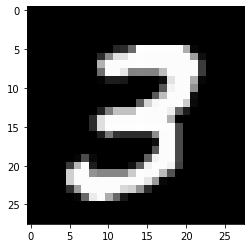

target_class=3


In [305]:
%matplotlib inline 
target = target_img.numpy().reshape((28,28))
target = target.astype(np.float32)
plt.imshow(target, cmap="gray")
plt.show()
target_class = eval_model(model, target)
print(f'{target_class=}')

In [313]:
final = boundary_attack(model, eval_model, target, target_class, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

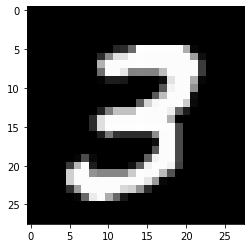

Image class: 3


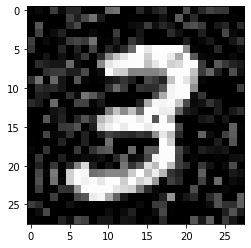

Adversarial class: 8 

L2 norm between images: 11.087442514314356


In [318]:
%matplotlib inline 

plt.imshow(target, cmap="gray")
plt.show()
print(f'Image class: {eval_model(model, target)}')


plt.imshow(final.clip(0,1), cmap="gray")
plt.show()
print(f'Adversarial class: {eval_model(model, final.clip(0,1))} \n')


print(f'L2 norm between images: {np.linalg.norm(final.clip(0,1) -  target) }')

In [179]:
final

array([[ 4.81727114e-03,  6.11714227e-03,  4.58516832e-03,
         1.73163100e-03,  5.10287564e-03,  1.03899380e-02,
         3.57683795e-03,  1.06240464e-02,  1.15596289e-02,
         2.46596592e-03,  2.19884492e-03,  1.88779249e-03,
         1.08410418e-03,  9.62409284e-03,  7.61081977e-03,
         5.45676565e-03,  6.78887358e-04,  4.04682569e-03,
         1.30294065e-03,  1.00703286e-02,  1.18280565e-02,
         9.81837697e-03,  1.52773526e-03,  1.26365386e-02,
         3.83121986e-03,  1.28161777e-02,  2.76688742e-03,
         7.91278575e-03],
       [ 3.54780327e-03,  1.33230910e-02,  1.37829231e-02,
         2.01575784e-03,  9.36886016e-03,  9.37739201e-03,
         1.05953235e-02,  1.03037665e-02,  3.77464574e-03,
         9.73883830e-03,  1.05931852e-02,  1.03475032e-02,
         1.20437024e-02,  2.41564517e-03,  1.74493890e-03,
         2.30837869e-03,  1.37811955e-02,  2.14424683e-04,
         8.30185227e-03,  4.70843771e-03,  1.75744342e-03,
         5.04247611e-03,  1.29